In [1]:
%load_ext autoreload

In [2]:
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 

In [67]:
import functools
from time import perf_counter
import kooplearn
import numpy as np
import matplotlib.pyplot as plt
import pnstyler.styler as styler
import ml_confs

In [115]:
configs = ml_confs.from_dict({
    'train_samples': 10_000
})

In [116]:
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation

In [117]:
from kooplearn.datasets import Lorenz63

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples)
# Data rescaling
data = raw_data - np.mean(raw_data, axis=0)
data /= np.max(np.abs(data), axis=0)

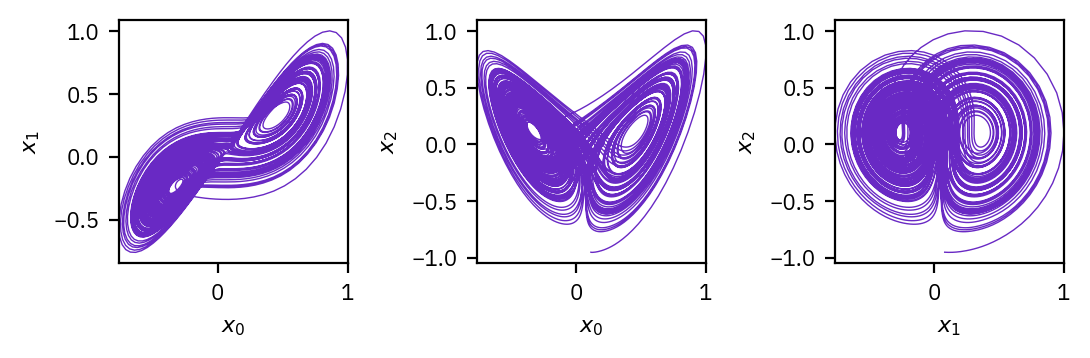

In [118]:
from itertools import combinations
fig, ax = plt.subplots(ncols=3, figsize = styler.figsize(width_to_height=3), layout='tight')
for i, (x, y) in enumerate(combinations(range(3), 2)):
    ax[i].plot(data[:, x], data[:, y], lw=0.5)
    ax[i].set_xlabel(f'$x_{x}$')
    ax[i].set_ylabel(f'$x_{y}$')

## Estimator fitting

In [119]:
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial.distance import pdist
from kooplearn.models import KernelDMD
from kooplearn.data import traj_to_contexts

# Length scale of the kernel: median of the pairwise distances of the dataset
data_pdist = pdist(data)
kernel = RBF(length_scale=np.median(data_pdist))
train_data = traj_to_contexts(data)

In [120]:
models_PCR = {
    'KernelDMD': KernelDMD(kernel=kernel, reduced_rank=False, tikhonov_reg=1e-6, rank = 20, svd_solver='arnoldi'),
    'RandSVDKernelDMD': KernelDMD(kernel=kernel, reduced_rank=False, svd_solver='randomized', tikhonov_reg=1e-6, rank = 20)
}

models_RRR = {
    'KernelDMD': KernelDMD(kernel=kernel, reduced_rank=True, tikhonov_reg=1e-6, svd_solver='arnoldi', rank = 20),
    'RandSVDKernelDMD': KernelDMD(kernel=kernel, reduced_rank=True, svd_solver='randomized', tikhonov_reg=1e-6, rank = 20, n_oversamples=10, rng_seed=0)
}

In [121]:
def runner(models):
    results = {}
    for name, model in models.items():
        print(f'Running {name}')
        model, fit_time = timer(model.fit)(train_data, verbose=False)
        results[name] = {
            'model': model,
            'fit_time': fit_time,
            'train_risk': model.risk()
        }
    return results

In [124]:
results = runner(models_RRR)

Running KernelDMD


/Users/pietronovelli/code_repos/kooplearn/kooplearn/_src/operator_regression/dual.py:68: RuntimeWarning: invalid value encountered in matmul
  norm_inducing_op = (K_Xn @ K_Xn.T) + tikhonov_reg * K_X


Running RandSVDKernelDMD


In [125]:
# Print results:
for name, res in results.items():
    print(f'{name}:\n\tFit time: {res["fit_time"]:.2f}s\n\tTrain risk: {res["train_risk"]:.5e}')

KernelDMD:
	Fit time: 34.16s
	Train risk: 5.39587e-04
RandSVDKernelDMD:
	Fit time: 7.34s
	Train risk: 5.40461e-04
